<a href="https://colab.research.google.com/github/JayasekaraMGCM/TDM-Assignment/blob/main/3D_stylized_Image_maker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
img_dir = '/tmp/nst'
if not os.path.exists(img_dir):
    os.makedirs(img_dir)
!wget --quiet -P /tmp/nst/ https://c4.wallpaperflare.com/wallpaper/601/786/348/anime-street-scenic-buildings-bicycle-wallpaper-preview.jpg
!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/en/c/ca/Betong_town_street.JPG

In [2]:
!git clone https://github.com/sniklaus/3d-ken-burns.git

Cloning into '3d-ken-burns'...
remote: Enumerating objects: 167, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 167 (delta 19), reused 31 (delta 12), pack-reused 125
Receiving objects: 100% (167/167), 347.60 KiB | 11.99 MiB/s, done.
Resolving deltas: 100% (92/92), done.


Importing the libraries

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['axes.grid'] = False

import numpy as np
from PIL import Image
import time
import functools

In [4]:
%tensorflow_version 1.x
import tensorflow as tf

from tensorflow.python.keras.preprocessing import image as kp_image
from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K

TensorFlow 1.x selected.


In [5]:
tf.enable_eager_execution()
print("Eager execution: {}".format(tf.executing_eagerly()))

Eager execution: True


In [6]:
# Set up some global values here
content_path = '/tmp/nst/Betong_town_street.JPG'
style_path = '/tmp/nst/anime-street-scenic-buildings-bicycle-wallpaper-preview.jpg'


Visualize the input

In [7]:
def load_img(path_to_img):
  max_dim = 512
  img = Image.open(path_to_img)
  long = max(img.size)
  scale = max_dim/long
  img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)
  
  img = kp_image.img_to_array(img)
  
  # We need to broadcast the image array such that it has a batch dimension 
  img = np.expand_dims(img, axis=0)
  return img

In [8]:
def imshow(img, title=None):
  # Remove the batch dimension
  out = np.squeeze(img, axis=0)
  # Normalize for display 
  out = out.astype('uint8')
  plt.imshow(out)
  if title is not None:
    plt.title(title)
  plt.imshow(out)

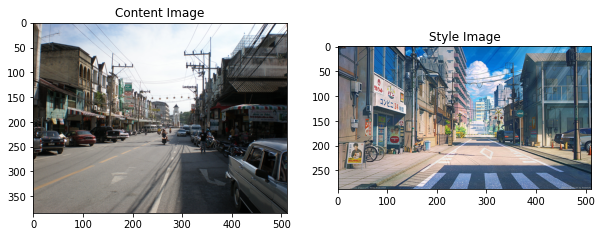

In [9]:
plt.figure(figsize=(10,10))

content = load_img(content_path).astype('uint8')
style = load_img(style_path).astype('uint8')

plt.subplot(1, 2, 1)
imshow(content, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style, 'Style Image')
plt.show()

Starting to load and process

In [10]:
def load_and_process_img(path_to_img):
  img = load_img(path_to_img)
  img = tf.keras.applications.vgg19.preprocess_input(img)
  return img

In [11]:
def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
  if len(x.shape) != 3:
    raise ValueError("Invalid input to deprocessing image")
  
  # perform the inverse of the preprocessing step
  x[:, :, 0] += 100.939
  x[:, :, 1] += 100.779
  x[:, :, 2] += 100.68
  x = x[:, :, ::-1]

  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [12]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer we are interested in
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

Begin the model work

In [13]:
def get_model():
 
  
  vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  style_outputs = [vgg.get_layer(name).output for name in style_layers]
  content_outputs = [vgg.get_layer(name).output for name in content_layers]
  model_outputs = style_outputs + content_outputs

  return models.Model(vgg.input, model_outputs)

Calculating the loss

In [14]:
def get_content_loss(base_content, target):
  return tf.reduce_mean(tf.square(base_content - target))

In [15]:
def gram_matrix(input_tensor):
  
  channels = int(input_tensor.shape[-1])
  a = tf.reshape(input_tensor, [-1, channels])
  n = tf.shape(a)[0]
  gram = tf.matmul(a, a, transpose_a=True)
  return gram / tf.cast(n, tf.float32)

def get_style_loss(base_style, gram_target):
 

  height, width, channels = base_style.get_shape().as_list()
  gram_style = gram_matrix(base_style)
  
  return tf.reduce_mean(tf.square(gram_style - gram_target))

Apply style image to the content image

In [16]:
def get_feature_representations(model, content_path, style_path):
  

  content_image = load_and_process_img(content_path)
  style_image = load_and_process_img(style_path)
  
  
  style_outputs = model(style_image)
  content_outputs = model(content_image)
  
  
  style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
  content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
  return style_features, content_features

In [17]:
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
 
  style_weight, content_weight = loss_weights
  

  model_outputs = model(init_image)
  
  style_output_features = model_outputs[:num_style_layers]
  content_output_features = model_outputs[num_style_layers:]
  
  style_score = 0
  content_score = 0

  
  weight_per_style_layer =1.0 / float(num_style_layers)
  for target_style, comb_style in zip(gram_style_features, style_output_features):
    style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)
    
  
  weight_per_content_layer = 1.0/ float(num_content_layers)
  for target_content, comb_content in zip(content_features, content_output_features):
    content_score += weight_per_content_layer* get_content_loss(comb_content[0], target_content)
  
  style_score *= style_weight
  content_score *= content_weight

 
  loss = style_score + content_score 
  return loss, style_score, content_score

In [18]:
def compute_grads(cfg):
  with tf.GradientTape() as tape: 
    all_loss = compute_loss(**cfg)

  total_loss = all_loss[0]
  return tape.gradient(total_loss, cfg['init_image']), all_loss

In [19]:
import IPython.display

def run_style_transfer(content_path, 
                       style_path,
                       num_iterations=1000,
                       content_weight=2000, 
                       style_weight=0.0001): 
  
  model = get_model() 
  for layer in model.layers:
    layer.trainable = False
  
  
  style_features, content_features = get_feature_representations(model, content_path, style_path)
  gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]
  
  
  init_image = load_and_process_img(content_path)
  init_image = tf.Variable(init_image, dtype=tf.float32)
  
  opt = tf.train.AdamOptimizer(learning_rate=5, beta1=0.99, epsilon=1e-1)

 
  iter_count = 1
  
 
  best_loss, best_img = float('inf'), None
  
 
  loss_weights = (style_weight, content_weight)
  cfg = {
      'model': model,
      'loss_weights': loss_weights,
      'init_image': init_image,
      'gram_style_features': gram_style_features,
      'content_features': content_features
  }
    
 
  num_rows = 2
  num_cols = 5
  display_interval = num_iterations/(num_rows*num_cols)
  start_time = time.time()
  global_start = time.time()
  
  norm_means = np.array([103.939, 116.779, 123.68])
  min_vals = -norm_means
  max_vals = 255 - norm_means   
  
  imgs = []
  for i in range(num_iterations):
    grads, all_loss = compute_grads(cfg)
    loss, style_score, content_score = all_loss
    opt.apply_gradients([(grads, init_image)])
    clipped = tf.clip_by_value(init_image, min_vals, max_vals)
    init_image.assign(clipped)
    end_time = time.time() 
    
    if loss < best_loss:
     
      best_loss = loss
      best_img = deprocess_img(init_image.numpy())

    if i % display_interval== 0:
      start_time = time.time()
      
     
      plot_img = init_image.numpy()
      plot_img = deprocess_img(plot_img)
      imgs.append(plot_img)
      IPython.display.clear_output(wait=True)
      IPython.display.display_png(Image.fromarray(plot_img))
      print('Iteration: {}'.format(i))        
      print('Total loss: {:.4e}, ' 
            'style loss: {:.4e}, '
            'content loss: {:.4e}, '
            'time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time))
  print('Total time: {:.4f}s'.format(time.time() - global_start))
  IPython.display.clear_output(wait=True)
  plt.figure(figsize=(14,4))
  for i,img in enumerate(imgs):
      plt.subplot(num_rows,num_cols,i+1)
      plt.imshow(img)
      plt.xticks([])
      plt.yticks([])
      
  return best_img, best_loss 

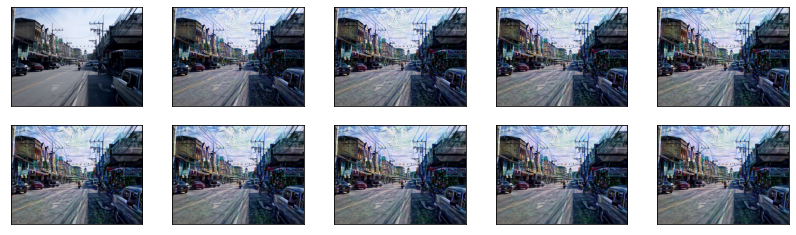

In [20]:
best, best_loss = run_style_transfer(content_path, 
                                     style_path, num_iterations=500)

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


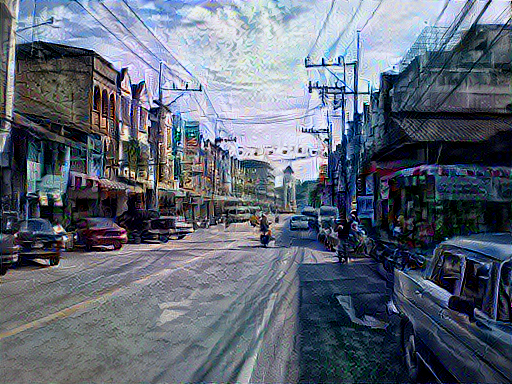

In [22]:
Image.fromarray(best)

In [23]:
from google.colab import files
from PIL import Image
import numpy as np


img = Image.fromarray(best, 'RGB')
img.save('/content/3d-ken-burns/images/out.jpg')


In [24]:
def show_results(best_img, content_path, style_path, show_large_final=True):
  plt.figure(figsize=(10, 5))
  content = load_img(content_path) 
  style = load_img(style_path)

  plt.subplot(1, 2, 1)
  imshow(content, 'Content Image')

  plt.subplot(1, 2, 2)
  imshow(style, 'Style Image')

  if show_large_final: 
    plt.figure(figsize=(10, 10))

    plt.imshow(best_img)
    plt.title('Output Image')
    plt.show()

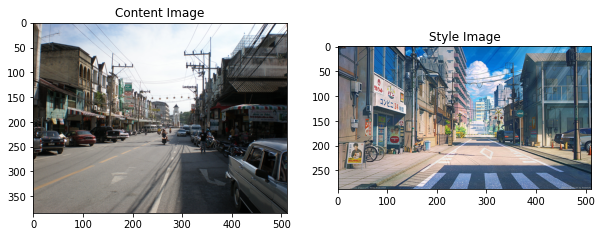

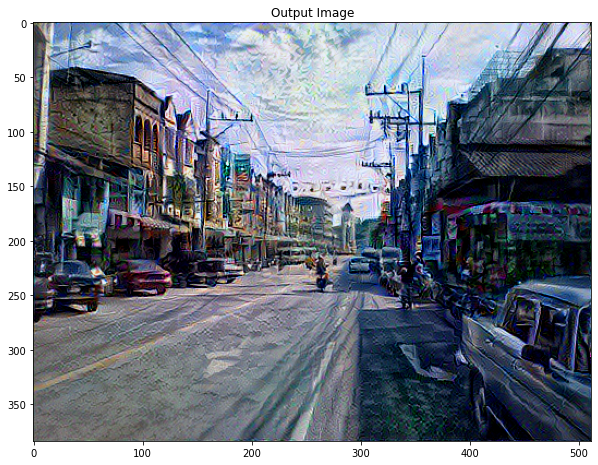

In [25]:
show_results(best, content_path, style_path)

3D ken burns  effect

In [26]:
!wget -O ./3d-ken-burns/models/disparity-estimation.pytorch http://content.sniklaus.com/kenburns/network-disparity.pytorch
!wget -O ./3d-ken-burns/models/disparity-refinement.pytorch http://content.sniklaus.com/kenburns/network-refinement.pytorch
!wget -O ./3d-ken-burns/models/pointcloud-inpainting.pytorch http://content.sniklaus.com/kenburns/network-inpainting.pytorch

--2021-06-25 14:00:33--  http://content.sniklaus.com/kenburns/network-disparity.pytorch
Resolving content.sniklaus.com (content.sniklaus.com)... 88.198.95.97
Connecting to content.sniklaus.com (content.sniklaus.com)|88.198.95.97|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 357438463 (341M) [application/octet-stream]
Saving to: ‘./3d-ken-burns/models/disparity-estimation.pytorch’

./3d-ken-burns/mode 100%[===================>] 340.88M  18.5MB/s    in 19s     

2021-06-25 14:00:52 (18.0 MB/s) - ‘./3d-ken-burns/models/disparity-estimation.pytorch’ saved [357438463/357438463]

--2021-06-25 14:00:52--  http://content.sniklaus.com/kenburns/network-refinement.pytorch
Resolving content.sniklaus.com (content.sniklaus.com)... 88.198.95.97
Connecting to content.sniklaus.com (content.sniklaus.com)|88.198.95.97|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2438928 (2.3M) [application/octet-stream]
Saving to: ‘./3d-ken-burns/models/disparity-ref

In [27]:
import chainer
chainer.print_runtime_info()

ModuleNotFoundError: ignored

In [ ]:
import os
os.environ['CUDA_HOME'] = "/usr/local/cuda"

In [ ]:
!pip install moviepy

In [ ]:
cd /content/3d-ken-burns

In [ ]:

!mkdir results

In [ ]:
!for image in ./images/out.jpg; do python autozoom.py --in $image --out ./results/$(basename $image | cut -f1 -d '.').mp4; done

In [ ]:
!pip install chainer==4.1.0



In [ ]:
for filename in os.listdir("./results"):
  extension = os.path.splitext(filename)[-1].lower()
  if extension == ".mp4" and filename == "out.mp4":
    files.download("./results/" + filename)